**Importing Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

**Data Preprocessing**

In [ ]:
traffic_data = pd.read_csv('/content/traffic.csv', parse_dates=['DateTime'])

print(traffic_data.head())

print(traffic_data['DateTime'].dtype)

             DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041
datetime64[ns]


In [ ]:
# Add time-based features
traffic_data['Hour'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek
traffic_data['Month'] = traffic_data['DateTime'].dt.month

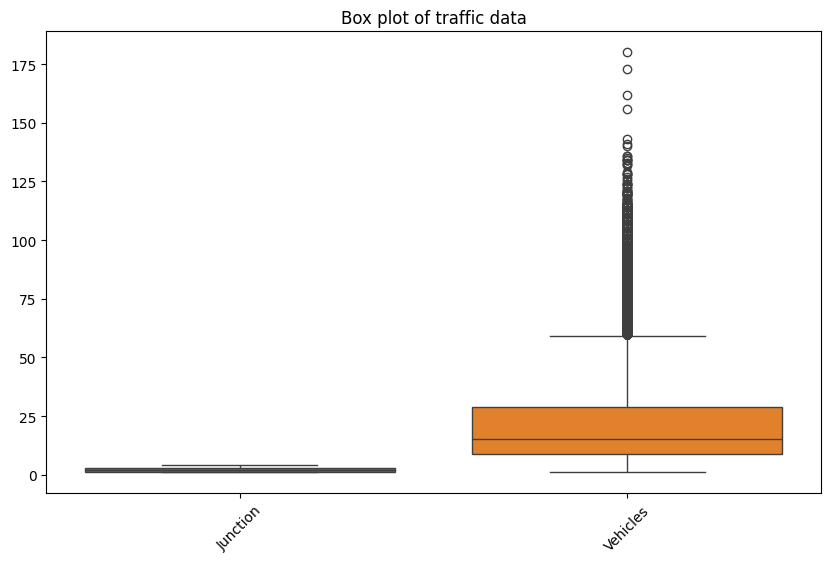

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=traffic_data[['Junction', 'Vehicles']])
plt.title('Box plot of traffic data')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
traffic_data_normalized = scaler.fit_transform(traffic_data[['Junction', 'Vehicles', 'Hour', 'DayOfWeek', 'Month']])

traffic_data_normalized = pd.DataFrame(traffic_data_normalized, columns=['Junction', 'Vehicles', 'Hour', 'DayOfWeek', 'Month'])

# Define features (X) and target variable (y)
X = traffic_data_normalized[['Junction', 'Hour', 'DayOfWeek', 'Month']]
y = traffic_data_normalized['Vehicles']

In [ ]:
#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (38496, 4) (38496,)
Testing set shape: (9624, 4) (9624,)


In [ ]:
# Defining the threshold for outliers
Q1 = traffic_data['Vehicles'].quantile(0.25)
Q3 = traffic_data['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
outlier_mask = (traffic_data['Vehicles'] < (Q1 - threshold * IQR)) | (traffic_data['Vehicles'] > (Q3 + threshold * IQR))
traffic_data_cleaned = traffic_data[~outlier_mask]

In [ ]:
scaler = MinMaxScaler()
traffic_data_normalized = scaler.fit_transform(traffic_data_cleaned[['Junction', 'Vehicles']])

# Convert normalized data back to DataFrame
traffic_data_normalized = pd.DataFrame(traffic_data_normalized, columns=['Junction', 'Vehicles'])

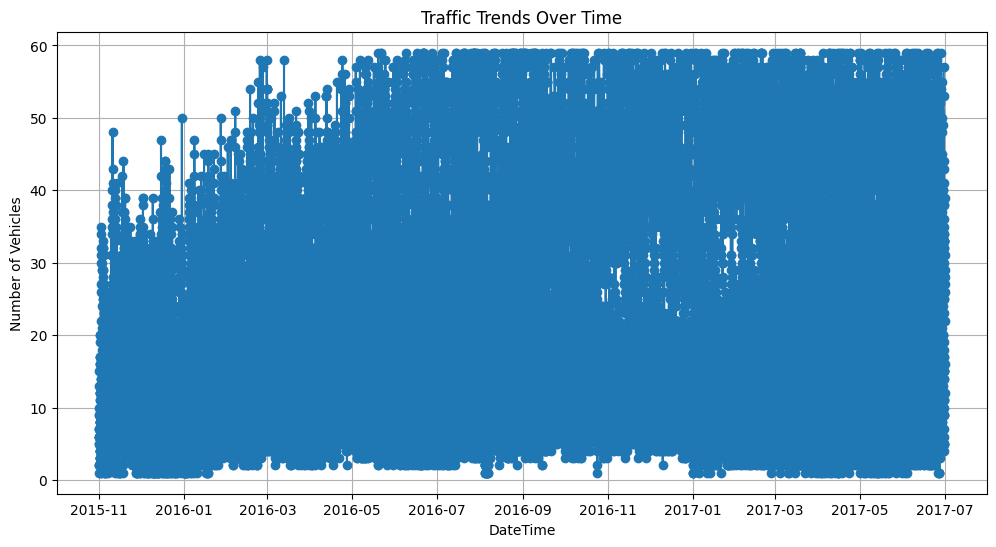

In [ ]:
# Time Series Analysis: Visualize traffic trends over time
plt.figure(figsize=(12, 6))
plt.plot(traffic_data_cleaned['DateTime'], traffic_data_cleaned['Vehicles'], marker='o', linestyle='-')
plt.title('Traffic Trends Over Time')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()

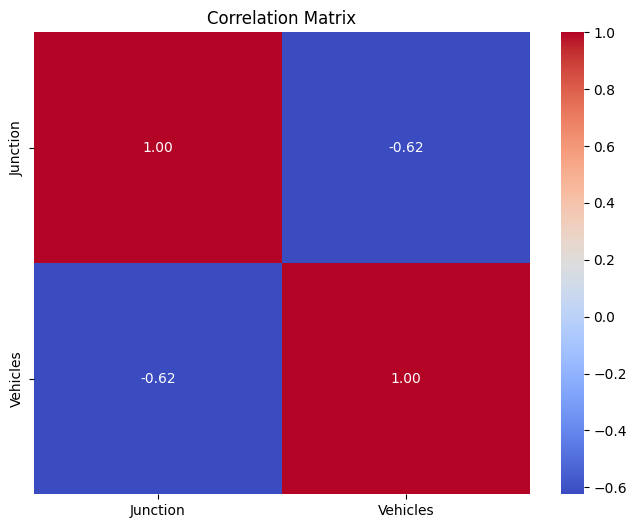

In [ ]:
# Correlation Analysis:
# Calculate correlation matrix
correlation_matrix = traffic_data_cleaned[['Junction', 'Vehicles']].corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
X = traffic_data_normalized[['Junction']]
y = traffic_data_normalized['Vehicles']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (35602, 1) (35602,)
Testing set shape: (8901, 1) (8901,)


**Model Building and Training**

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
degree = 2

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Display the shapes of the new feature sets
print("Polynomial features - Training set shape:", X_train_poly.shape)
print("Polynomial features - Testing set shape:", X_test_poly.shape)

Polynomial features - Training set shape: (35602, 3)
Polynomial features - Testing set shape: (8901, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                128       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
891/891 [==============================] - 5s 4ms/step - loss: 0.0307 - mae: 0.1296 - val_loss: 0.0255 - val_mae: 0.1246
Epoch 2/30
891/891 [==============================] - 3s 3ms/step - loss: 0.0257 - mae: 0.1216 - val_loss: 0.0251 - val_mae: 0.1189
Epoch 3/30
891/891 [==

**Model evaluation**

In [ ]:
y_pred = model.predict(X_test)

y_pred = y_pred.squeeze()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

279/279 [==============================] - 0s 1ms/step
Mean Absolute Error (MAE): 0.12144824484133637
Root Mean Squared Error (RMSE): 0.16145064823908836


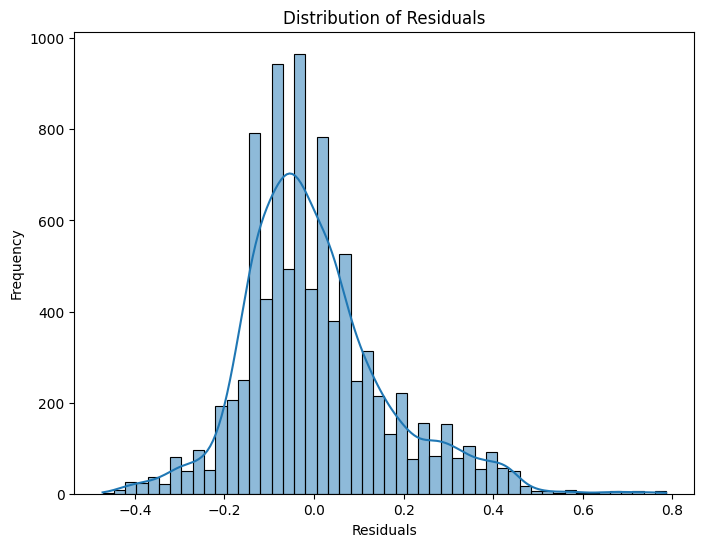

In [ ]:
y_pred = y_pred.reshape(-1,)
residuals = y_test - y_pred

# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

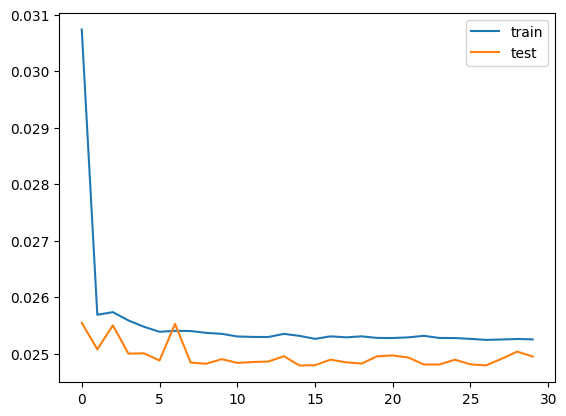

279/279 [==============================] - 0s 1ms/step
Test RMSE: 0.161


In [ ]:
from sklearn.metrics import mean_squared_error

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(X_test)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)